# Code Section:-



# Importing Libraries

In [74]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from imblearn.over_sampling import SMOTE
import xgboost as xgb
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve

# Data Loading & Exploration

In [2]:
df = pd.read_csv(r"C:\Users\HP\Downloads\Fraud.csv")

In [3]:
df.shape

(6362620, 11)

In [4]:
print("Columns:", df.columns.tolist())

Columns: ['step', 'type', 'amount', 'nameOrig', 'oldbalanceOrg', 'newbalanceOrig', 'nameDest', 'oldbalanceDest', 'newbalanceDest', 'isFraud', 'isFlaggedFraud']


In [5]:
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


In [7]:
print("\nMissing per column:\n", df.isnull().sum())


Missing per column:
 step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64


# EDA:- 

# Fraud vs Non-Fraud Transaction Class Distribution

In [11]:
#0 = Non-fraudulent transaction
#1 = Fraudulent transaction
class_counts = df['isFraud'].value_counts().sort_index()
print("Class Distribution:",class_counts)
print("\nFraud Distribution (percentage):\n",df['isFraud'].value_counts(normalize = True) * 100)

Class Distribution: isFraud
0    6354407
1       8213
Name: count, dtype: int64

Fraud Distribution (percentage):
 isFraud
0    99.870918
1     0.129082
Name: proportion, dtype: float64


# Distribution of Transactions by Type

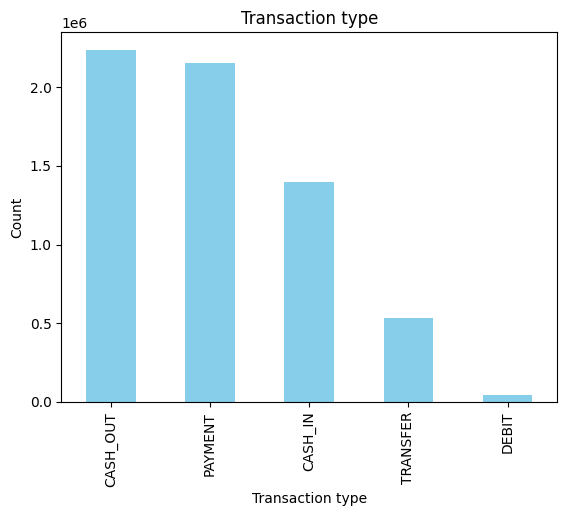

In [12]:
df['type'].value_counts().plot(kind="bar",title="Transaction type",color = "skyblue")
plt.xlabel("Transaction type")
plt.ylabel("Count")
plt.show()

# Fraud Rate Comparison Across Transaction Types

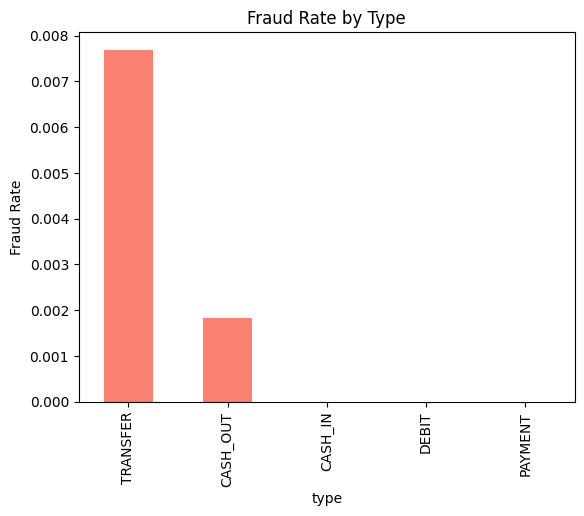

In [13]:
fraud_by_type = df.groupby("type")["isFraud"].mean().sort_values(ascending = False)
fraud_by_type.plot(kind = "bar",title = "Fraud Rate by Type",color = "salmon")
plt.ylabel("Fraud Rate")
plt.show()

In [14]:
df['amount'].describe().astype(int)

count     6362620
mean       179861
std        603858
min             0
25%         13389
50%         74871
75%        208721
max      92445516
Name: amount, dtype: int32

# Amount vs Fraud Status (<50K)

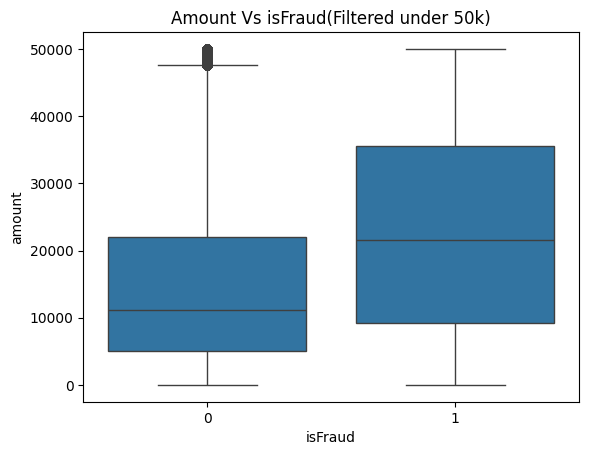

In [15]:
sns.boxplot(data= df[df['amount'] < 50000],x = "isFraud", y = "amount")
plt.title("Amount Vs isFraud(Filtered under 50k)")
plt.show()

# Derived Features: Origin & Destination Balance Difference"

In [16]:
df["balanceDiffOrig"] = df['oldbalanceOrg'] - df['newbalanceOrig']
df["balanceDiffDest"] = df['newbalanceDest'] - df['oldbalanceDest']

# IQR-Based Outlier Treatment

In [17]:
import numpy as np

for col in ['amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest']:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    df[col] = np.where(df[col] > upper_bound, upper_bound, df[col])
    df[col] = np.where(df[col] < lower_bound, lower_bound, df[col])

print(df.shape)

(6362620, 13)


# Fraud vs Non-Fraud Transaction Distribution

Text(0.5, 1.0, 'Fraud vs Non-Fraud Transaction Distribution')

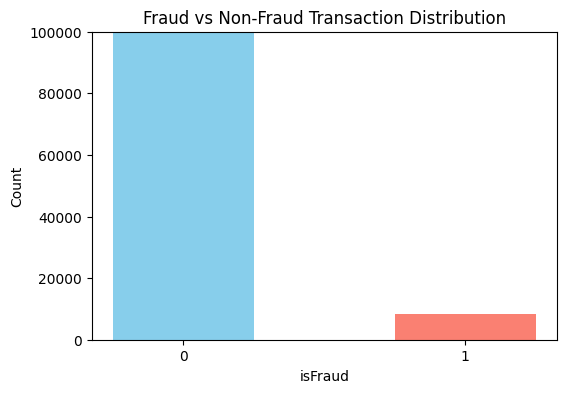

In [18]:
plt.figure(figsize=(6,4))
bars = plt.bar(class_counts.index.astype(str), class_counts.values, color=['skyblue','salmon'],width = 0.5)
plt.ylim(0, 10_0000)
plt.xlabel("isFraud")
plt.ylabel("Count")
plt.title("Fraud vs Non-Fraud Transaction Distribution")

In [19]:
corr = df[["amount","oldbalanceOrg","newbalanceOrig","oldbalanceDest","newbalanceDest","isFraud"]].corr()
corr

,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud
amount,1.000000,0.023468,0.050487,0.412529,0.497708,0.048094
oldbalanceOrg,0.023468,1.000000,0.858632,0.105036,0.038118,0.045966
newbalanceOrig,0.050487,0.858632,1.000000,0.120676,0.016830,-0.021092
oldbalanceDest,0.412529,0.105036,0.120676,1.000000,0.966351,-0.013570
newbalanceDest,0.497708,0.038118,0.016830,0.966351,1.000000,-0.001172
isFraud,0.048094,0.045966,-0.021092,-0.013570,-0.001172,1.000000


# Feature Correlation Heatmap

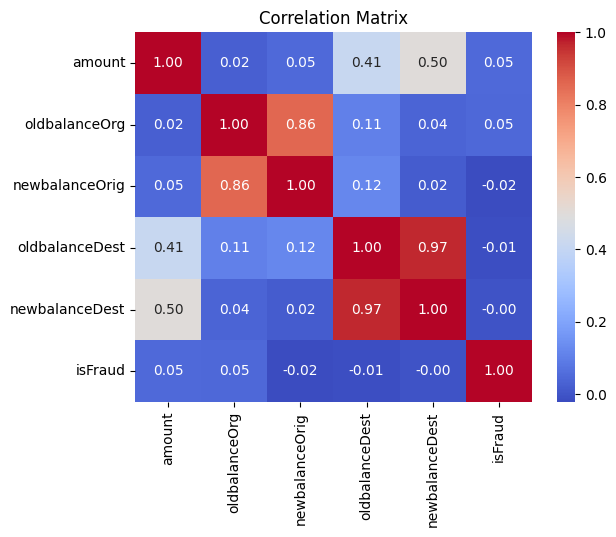

In [20]:
sns.heatmap(corr,annot=True,cmap="coolwarm",fmt = ".2f")
plt.title("Correlation Matrix")
plt.show()

In [54]:
df_model = df.drop(columns=["step", "nameOrig", "nameDest", "isFlaggedFraud"],axis = 1)

In [55]:
X = df_model.drop('isFraud', axis=1)
y = df_model['isFraud']

In [56]:
categorical_features = ['type']
one_hot_encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
preprocessor = ColumnTransformer(
    transformers=[('cat', one_hot_encoder, categorical_features)],
    remainder='passthrough'
)

In [57]:
import joblib
preprocessor.fit(X)
joblib.dump(preprocessor, 'preprocessor.pkl')
X = preprocessor.transform(X)


# Train-Test Split

In [58]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.3,random_state=42,stratify = y)

# Handle Imbalance (SMOTE)

In [59]:
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Model Selection

In [60]:
xgb_model = xgb.XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')
xgb_model.fit(X_train_resampled, y_train_resampled)
xgb_model.save_model('fraud_detection_model.json')

In [61]:
y_pred = xgb_model.predict(X_test)
y_probas = xgb_model.predict_proba(X_test)[:, 1]

# Model Evaluation

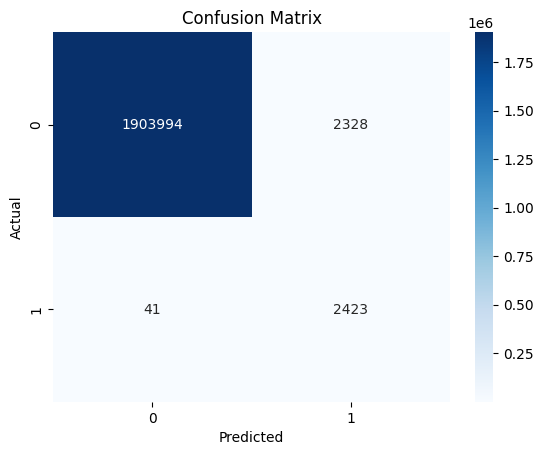

In [62]:
cm = confusion_matrix(y_test, y_pred_new)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show() 

In [63]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1906322
           1       0.42      0.99      0.59      2464

    accuracy                           1.00   1908786
   macro avg       0.71      0.99      0.80   1908786
weighted avg       1.00      1.00      1.00   1908786



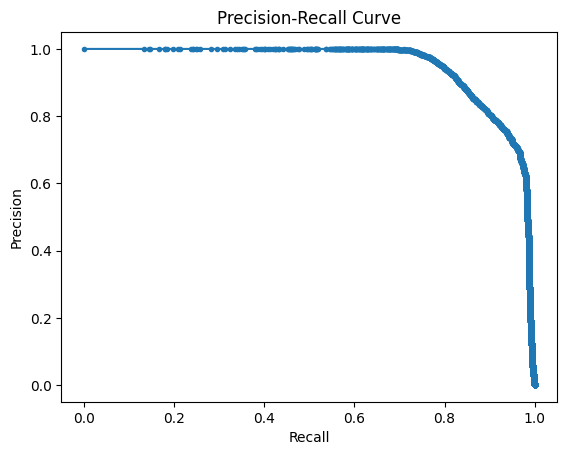

In [64]:
precision, recall, thresholds = precision_recall_curve(y_test, y_probas)
plt.plot(recall, precision, marker='.')
plt.title('Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()


# Final Model & Predictions

In [72]:
new_transaction_data = {
    'type': ['CASH_OUT'],
    'amount': [10000],
    'oldbalanceOrg': [100000],
    'newbalanceOrig': [10],
    'oldbalanceDest': [10000],
    'newbalanceDest': [20000],
    'balanceDiffOrig': [10000], 
    'balanceDiffDest': [10000]
}
new_df = pd.DataFrame(new_transaction_data)

loaded_preprocessor = joblib.load('preprocessor.pkl')
loaded_model = xgb.XGBClassifier()
loaded_model.load_model('fraud_detection_model.json')

new_data_processed = loaded_preprocessor.transform(new_df)
prediction = loaded_model.predict(new_data_processed)

print("\n--- New Prediction ---")
print(f"Prediction: {'Fraudulent' if prediction[0] == 1 else 'Not Fraudulent'}")



--- New Prediction ---
Prediction: Fraudulent


# Project Report Section:-

# 1. Data cleaning including missing values, outliers and multi-collinearity.

# 2. Describe your fraud detection model in elaboration.

# 3. How did you select variables to be included in the model?

# 4. Demonstrate the performance of the model by using best set of tools.

# 5. What are the key factors that predict fraudulent customer?

# 6. Do these factors make sense? If yes, How? If not, How not?

# 7. What kind of prevention should be adopted while company update its infrastructure?

# 8. Assuming these actions have been implemented, how would you determine if they work?